# Setup

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install opencv-python

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git && cd segment-anything-2 && pip install -e ".[demo]"

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image
from collections import OrderedDict

In [6]:
# select the device for computation
device = torch.device("cuda")
print(f"using device: {device}")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

using device: cuda


# Load SAM2 video predictor

If this is the first time you installed the sam2 package from the segment-anything-2 repo you'll need to restart your notebook kernel.

In [1]:
from sam2.sam2_video_predictor import SAM2VideoPredictor

model_id = "facebook/sam2-hiera-large"

# note: loading from HF does not seem to support modifying the model config so
# if you want to modify config values (i.e. set compile_image_encoder=True which
# enables torch.compile to accelerate image encoder inference) you'll probably
# want to use build_sam2_video_predictor() instead.
predictor = SAM2VideoPredictor.from_pretrained(model_id)

sam2_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

In [2]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_frame(frame_idx, frame):
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {frame_idx}")
    plt.imshow(frame)

The `VideoReader` class will use OpenCV to read a video frame by frame to simulate receiving frames on the fly in a live stream.

In [13]:
class VideoReader:
    def __init__(self, cap: cv2.VideoCapture):
        self.cap = cap
        self.frame_idx = 0

    def next_frame(self):
        _, frame = cap.read()

        idx = self.frame_idx
        self.frame_idx += 1

        # opencv uses bgr color mode
        # matplotlib uses rgb color mode
        # convert the opencv frame to rgb before displaying using matplotlib
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        return idx, rgb_frame

In [11]:
reader = VideoReader(cv2.VideoCapture("./bedroom.mp4"))

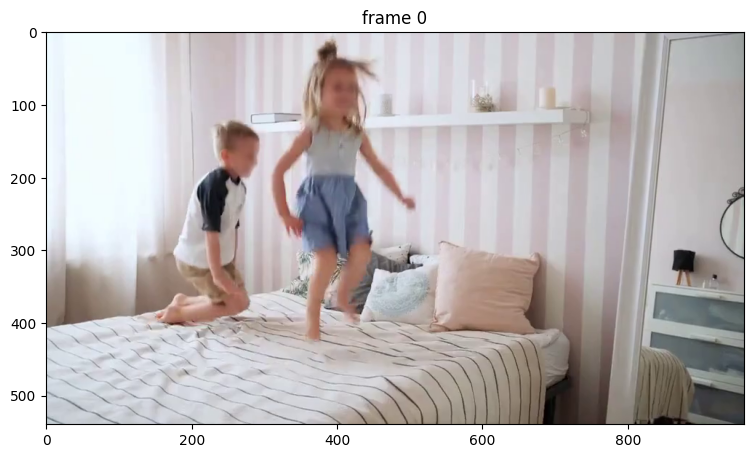

In [12]:
frame_idx, frame = reader.next_frame()
show_frame(frame_idx, frame)

# Initialize inference state

In [14]:
# based off of sam2.utils.misc.load_video_frames
def preprocess_frame(
    frame: np.ndarray,
    offload_video_to_cpu: bool = False,
    device: torch.device = torch.device("cuda")
) -> torch.Tensor:
    # resize and rescale to [0, 1]
    # image size for sam2-hiera-large - this could be different for another model
    image_size = 1024
    img = cv2.resize(frame, (image_size, image_size)) / 255.0
    
    # numpy.ndarray -> torch.Tensor
    # (H, W, C) -> (C, H, W)
    img = torch.from_numpy(img).permute(2, 0, 1).float()

    # The hardcoded values of img_mean and img_std are the mean and std dev of the ImageNet training dataset
    # A common practice during training is to normalize data by adjusting the data distribution using the mean and std dev
    # This should be done at inference time too so that the input data is in the same format as the data used during training
    # According to https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670
    # the mean and std dev of the ImageNet training dataset can work well out of the box especially if your training dataset looks similar
    # to the ImageNet dataset though there might be benefits to using the mean and std dev of your actual dataset.
    
    img_mean = (0.485, 0.456, 0.406)
    # Convert to torch.Tensor and add two new axes for broading when doing element-wise subtraction with the image
    img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None]
    
    img_std = (0.229, 0.224, 0.225)
    # Convert to torch.Tensor and add two new axes for broadcasting when doing element-wise division with the image
    img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None]

    if not offload_video_to_cpu:
        img = img.to(device)
        img_mean = img_mean.to(device)
        img_std = img_std.to(device)
    
    img -= img_mean
    img /= img_std
    
    return img.unsqueeze(0)

In [16]:
# a modified version of SAM2VideoPredictor.init_state() that accepts a single frame
@torch.inference_mode()
def init_state(
    frame: np.ndarray,
    offload_video_to_cpu=False,
    offload_state_to_cpu=False,
):
    """Initialize an inference state."""
    compute_device = predictor.device  # device of the model
    inference_state = {}

    # before processing the frame has shape (H, W, C)
    video_height = frame.shape[0]
    video_width = frame.shape[1]
    
    img = preprocess_frame(frame, offload_video_to_cpu, compute_device)
    
    inference_state["images"] = img
    inference_state["num_frames"] = 1
    # whether to offload the video frames to CPU memory
    # turning on this option saves the GPU memory with only a very small overhead
    inference_state["offload_video_to_cpu"] = offload_video_to_cpu
    # whether to offload the inference state to CPU memory
    # turning on this option saves the GPU memory at the cost of a lower tracking fps
    # (e.g. in a test case of 768x768 model, fps dropped from 27 to 24 when tracking one object
    # and from 24 to 21 when tracking two objects)
    inference_state["offload_state_to_cpu"] = offload_state_to_cpu
    # the original video height and width, used for resizing final output scores
    inference_state["video_height"] = video_height
    inference_state["video_width"] = video_width
    inference_state["device"] = compute_device
    if offload_state_to_cpu:
        inference_state["storage_device"] = torch.device("cpu")
    else:
        inference_state["storage_device"] = compute_device
    # inputs on each frame
    inference_state["point_inputs_per_obj"] = {}
    inference_state["mask_inputs_per_obj"] = {}
    # visual features on a small number of recently visited frames for quick interactions
    inference_state["cached_features"] = {}
    # values that don't change across frames (so we only need to hold one copy of them)
    inference_state["constants"] = {}
    # mapping between client-side object id and model-side object index
    inference_state["obj_id_to_idx"] = OrderedDict()
    inference_state["obj_idx_to_id"] = OrderedDict()
    inference_state["obj_ids"] = []
    # A storage to hold the model's tracking results and states on each frame
    inference_state["output_dict"] = {
        "cond_frame_outputs": {},  # dict containing {frame_idx: <out>}
        "non_cond_frame_outputs": {},  # dict containing {frame_idx: <out>}
    }
    # Slice (view) of each object tracking results, sharing the same memory with "output_dict"
    inference_state["output_dict_per_obj"] = {}
    # A temporary storage to hold new outputs when user interact with a frame
    # to add clicks or mask (it's merged into "output_dict" before propagation starts)
    inference_state["temp_output_dict_per_obj"] = {}
    # Frames that already holds consolidated outputs from click or mask inputs
    # (we directly use their consolidated outputs during tracking)
    inference_state["consolidated_frame_inds"] = {
        "cond_frame_outputs": set(),  # set containing frame indices
        "non_cond_frame_outputs": set(),  # set containing frame indices
    }
    # metadata for each tracking frame (e.g. which direction it's tracked)
    inference_state["tracking_has_started"] = False
    inference_state["frames_already_tracked"] = {}
    # Warm up the visual backbone and cache the image feature on frame 0
    predictor._get_image_feature(inference_state, frame_idx=0, batch_size=1)
    return inference_state

In [17]:
inference_state = init_state(frame)

# Step 1. Add a first click on the frame

/home/user/research-notebooks/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:607.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/user/research-notebooks/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/user/research-notebooks/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:609.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/user/research-notebooks/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning

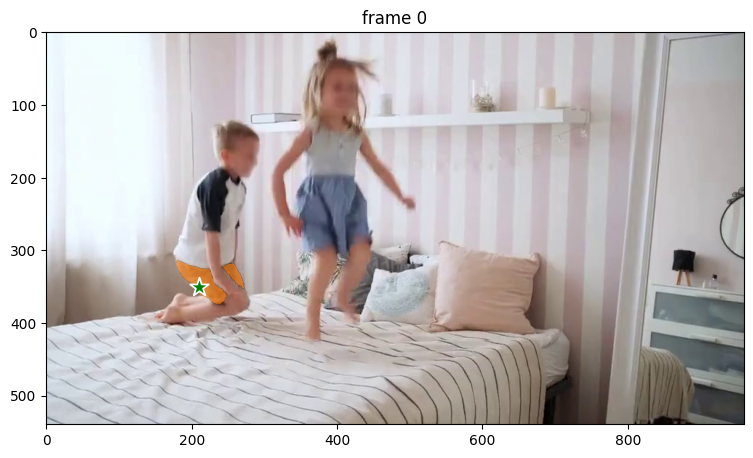

In [18]:
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
show_frame(frame_idx, frame)
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

# Step 2: Add a second click to refine the prediction

The first click only generated a mask for the shorts. We want to generate a mask for the boy so we have to add a second click.

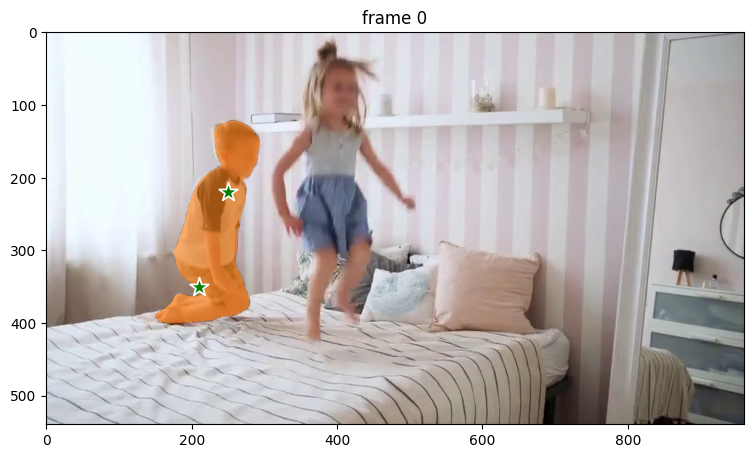

In [20]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
show_frame(frame_idx, frame)
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With both clicks we now have a mask for the boy.

# Step 3: Propagate masklet through rest of frames

We have a mask for the boy in a single frame and now we want a *masklet* across the video i.e. masks for the boy in every frame of the video.

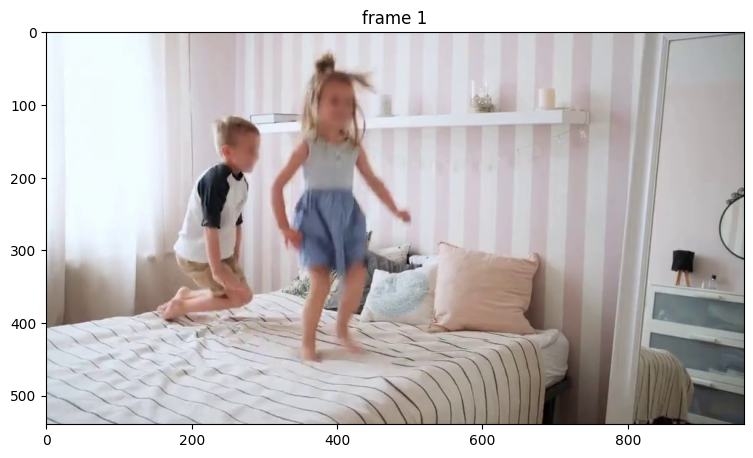

In [21]:
frame_idx, frame = reader.next_frame()

show_frame(frame_idx, frame)

In [29]:
# based on SAM2VideoPredictor.propagate_in_video()
@torch.inference_mode()
def track(inference_state, frame_idx, frame):  
    if not inference_state["tracking_has_started"]:
        predictor.propagate_in_video_preflight(inference_state)

    img = preprocess_frame(frame)

    # add to cache
    # TODO: need to evict from cache as more frames are received
    inference_state["num_frames"] += 1
    inference_state["images"] = torch.cat((inference_state["images"], img))
    
    output_dict = inference_state["output_dict"]
    consolidated_frame_inds = inference_state["consolidated_frame_inds"]
    obj_ids = inference_state["obj_ids"]
    num_frames = inference_state["num_frames"]
    batch_size = predictor._get_obj_num(inference_state)
    if len(output_dict["cond_frame_outputs"]) == 0:
        raise RuntimeError("No points are provided; please add points first")
    clear_non_cond_mem = predictor.clear_non_cond_mem_around_input and (
        self.clear_non_cond_mem_for_multi_obj or batch_size <= 1
    )

    reverse = False
    storage_key = "non_cond_frame_outputs"
    current_out, pred_masks = predictor._run_single_frame_inference(
        inference_state=inference_state,
        output_dict=output_dict,
        frame_idx=frame_idx,
        batch_size=batch_size,
        is_init_cond_frame=False,
        point_inputs=None,
        mask_inputs=None,
        reverse=reverse,
        run_mem_encoder=True
    )
    output_dict[storage_key][frame_idx] = current_out

    # Create slices of per-object outputs for subsequent interaction with each
    # individual object after tracking.
    predictor._add_output_per_object(
        inference_state, frame_idx, current_out, storage_key
    )
    inference_state["frames_already_tracked"][frame_idx] = {"reverse": reverse}

    # Resize the output mask to the original video resolution (we directly use
    # the mask scores on GPU for output to avoid any CPU conversion in between)
    _, video_res_masks = predictor._get_orig_video_res_output(inference_state, pred_masks)

    return obj_ids, video_res_masks

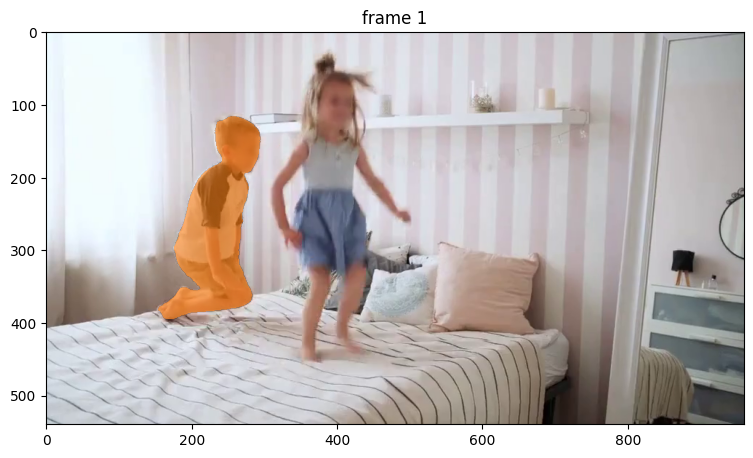

In [30]:
out_obj_ids, out_mask_logits = track(inference_state, frame_idx, frame)

# show the results on the current (interacted) frame
show_frame(frame_idx, frame)
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

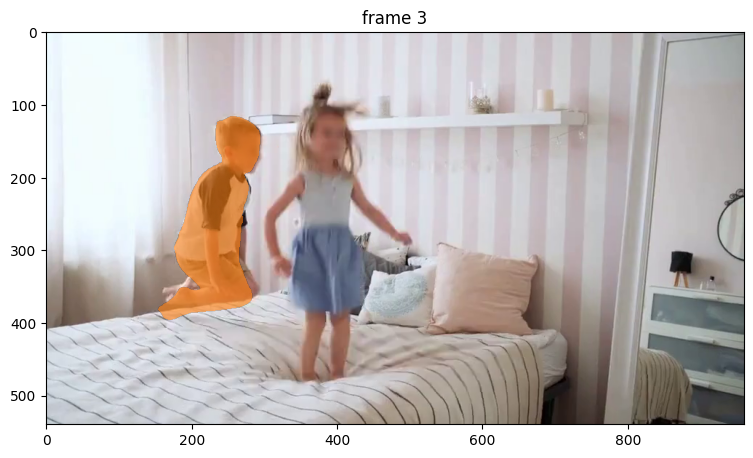

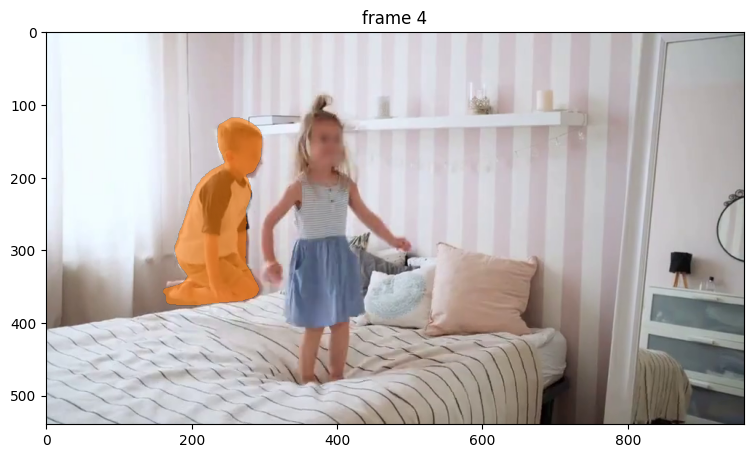

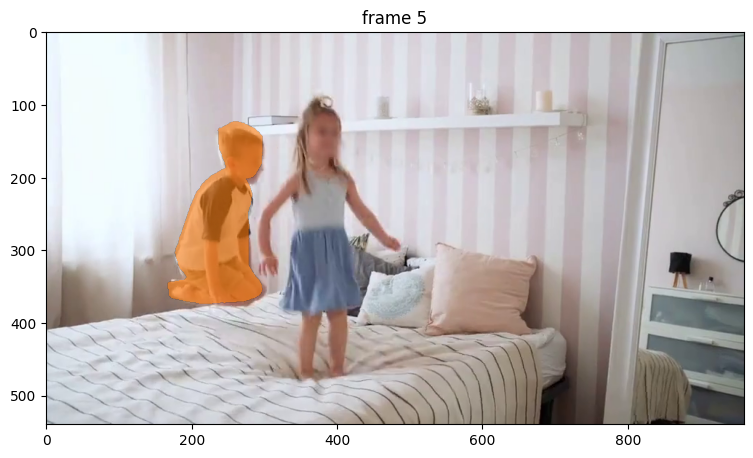

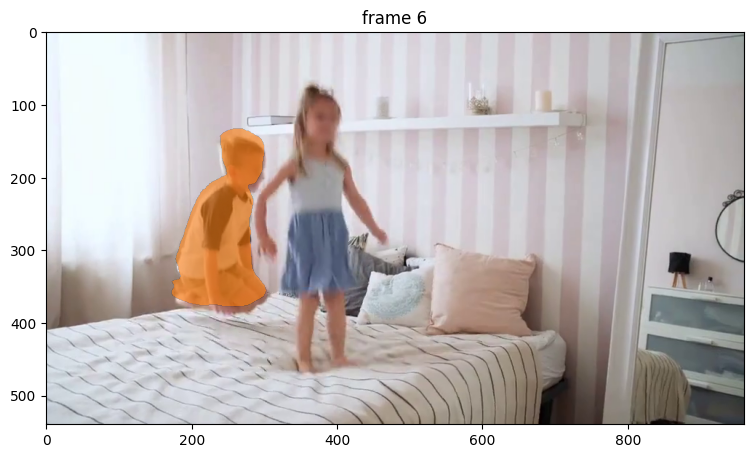

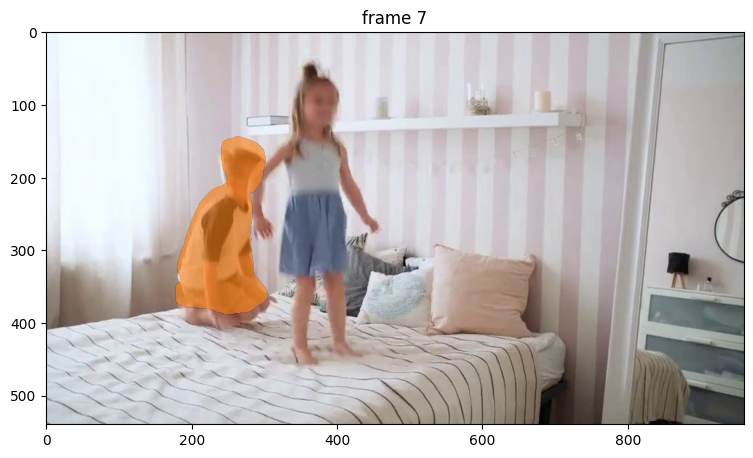

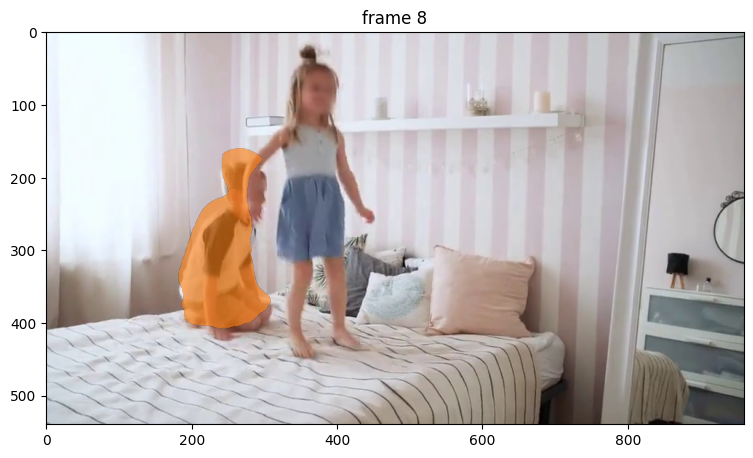

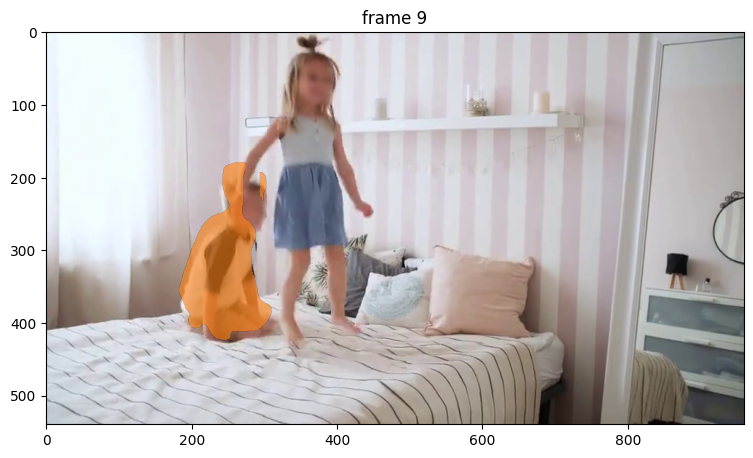

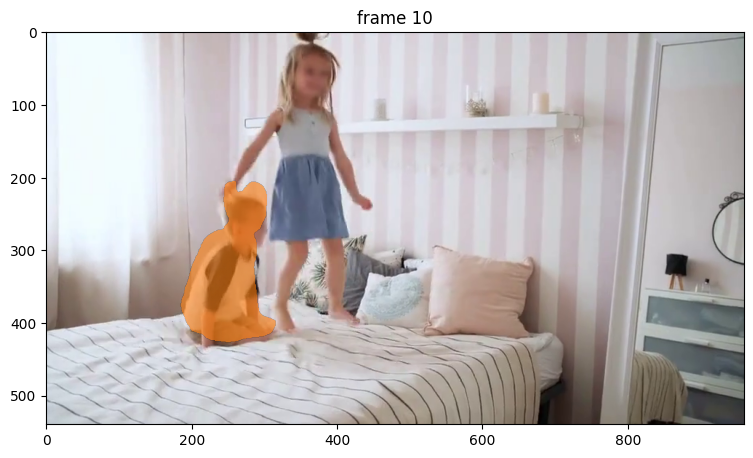

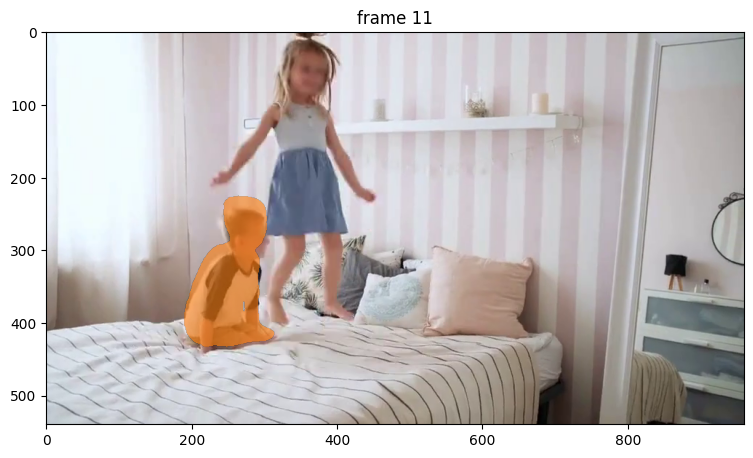

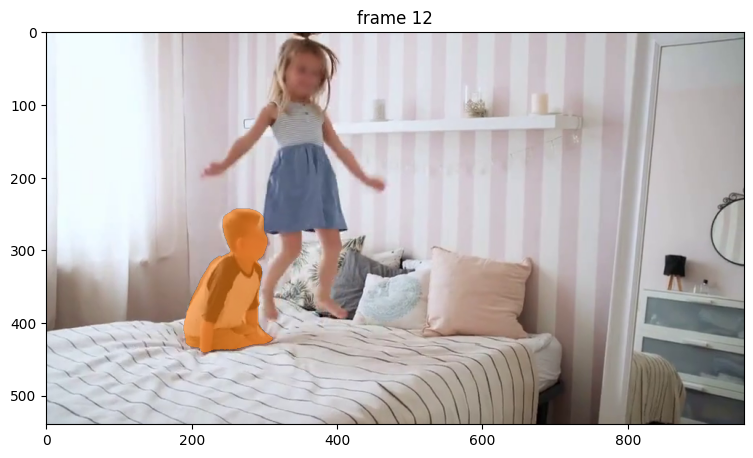

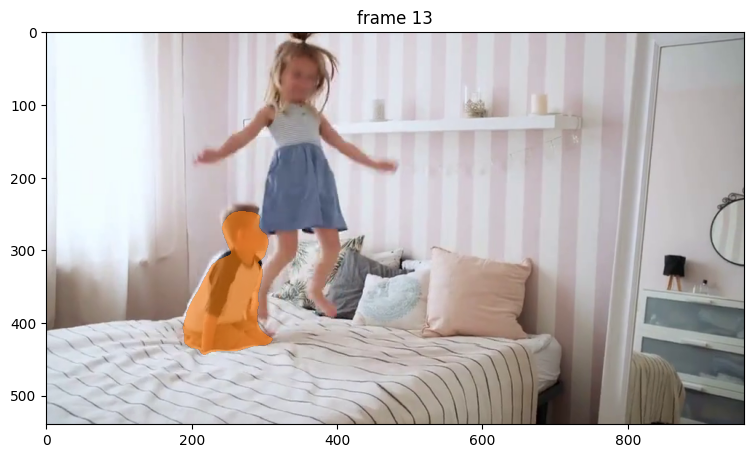

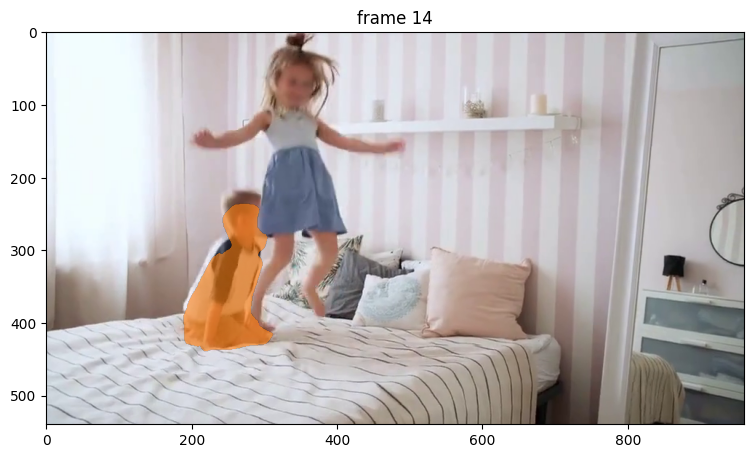

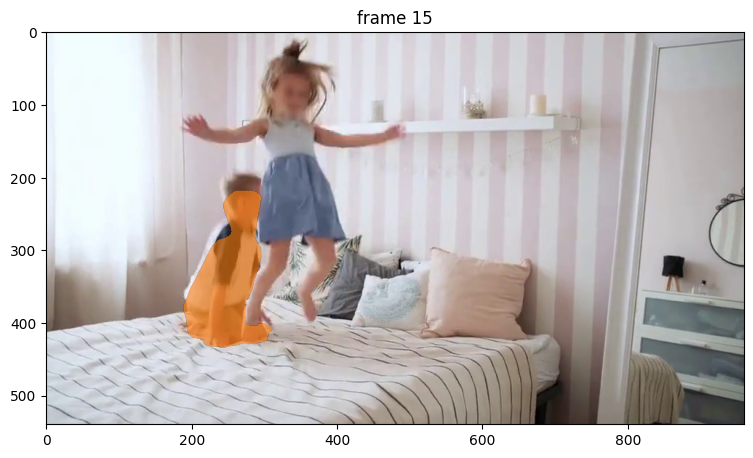

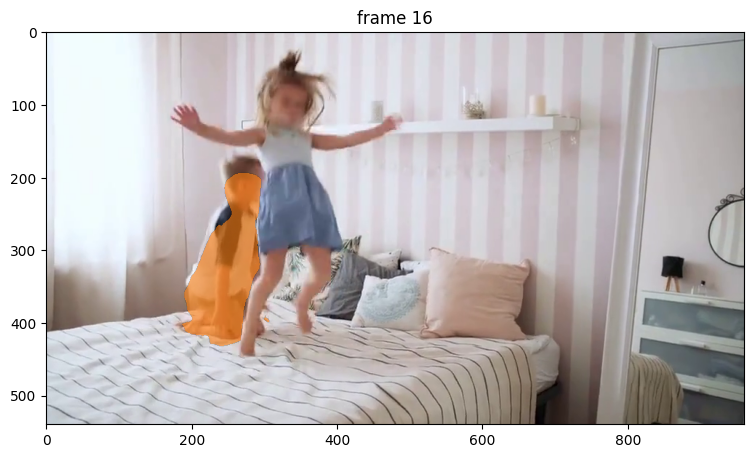

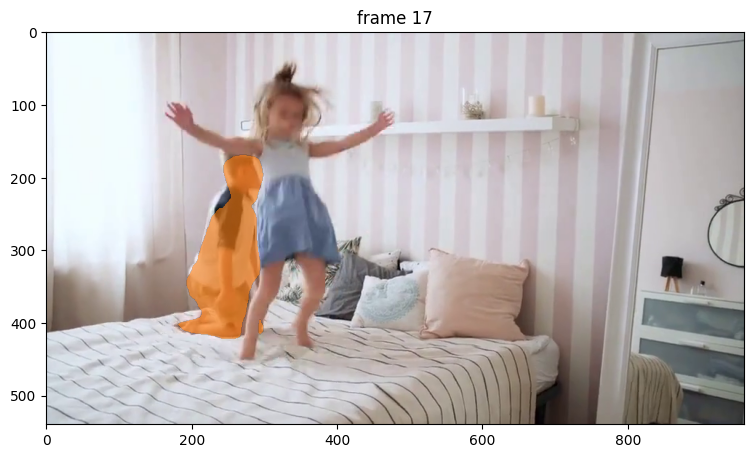

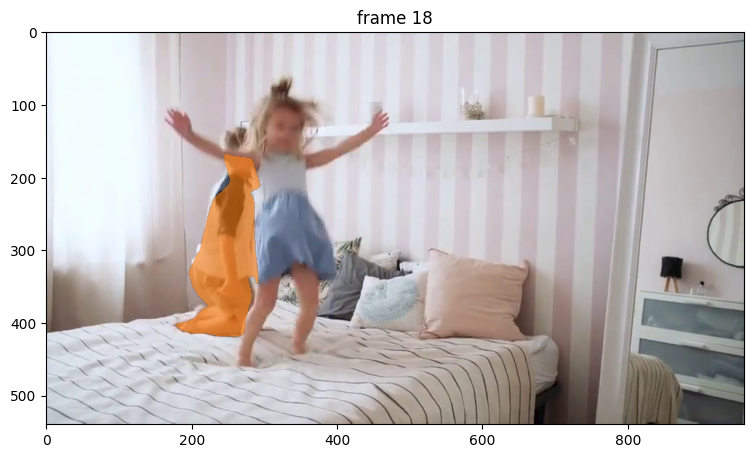

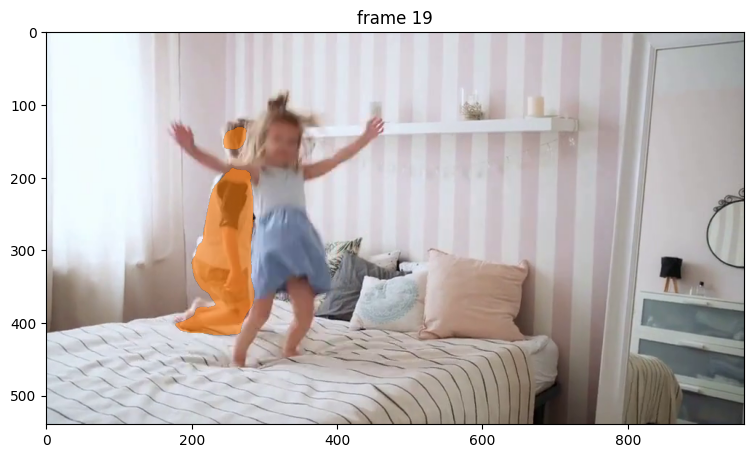

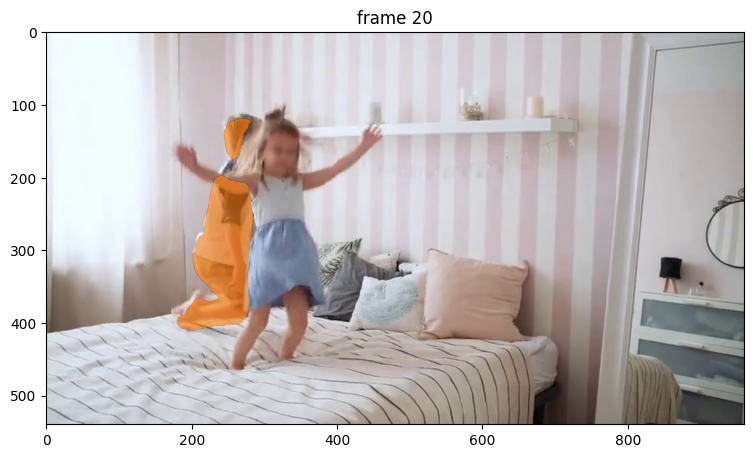

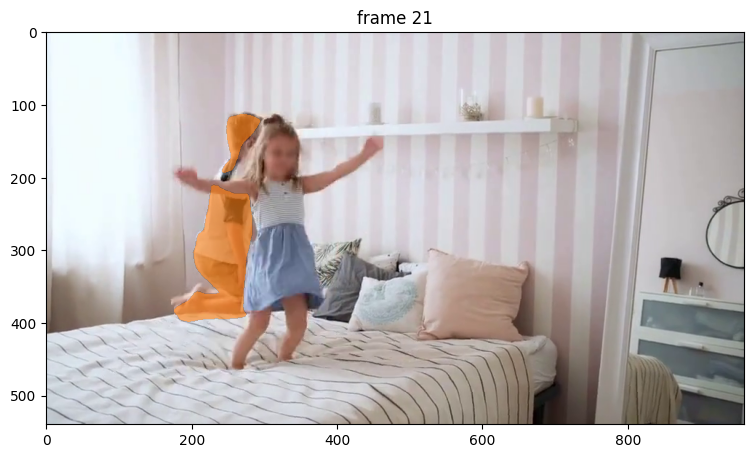

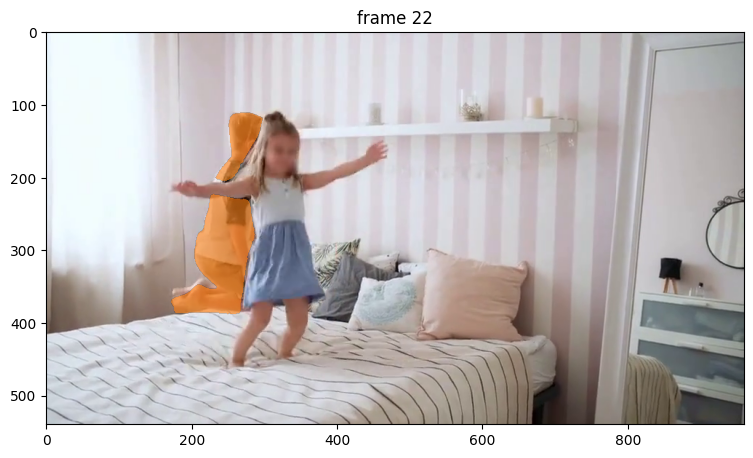

In [33]:
plt.close("all")

curr_num_frames = 0
max_num_frames = 20
while curr_num_frames < max_num_frames:
    frame_idx, frame = reader.next_frame()
    
    out_obj_ids, out_mask_logits = track(inference_state, frame_idx, frame)

    # show the results on the current (interacted) frame
    show_frame(frame_idx, frame)
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

    curr_num_frames += 1

# Compare with static video results

Let's see how the above results compare with the results of SAM2VideoPredictor on the same static video.

In [36]:
# reset state
predictor.reset_state(inference_state)

In [37]:
inference_state = predictor.init_state(video_path="./bedroom")

frame loading (JPEG): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.67it/s]


In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])